In [1]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load your dataset (here, using a smaller subset for demonstration)
with open('/kaggle/input/texts-dataset/texts.pkl', 'rb') as file:
    texts = pickle.load(file)
texts = texts[:15000]  # Use a subset for faster processing
print(f"Number of texts loaded: {len(texts)}")

# Tokenize Text Data and Limit Vocabulary Size
tokenizer = Tokenizer(oov_token="<OOV>", num_words=10000)
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1  # +1 for the padding index

# Generate input sequences for training
input_sequences = []
for line in texts:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Pad sequences to ensure uniform length
max_sequence_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

# Split into inputs (X) and labels (y)
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
print(X_train.shape)
print(y_train.shape)

Number of texts loaded: 15000
Training samples: 127808, Validation samples: 31952
(127808, 71)
(127808, 8748)


In [2]:
embedding_dim = 100  # Dimension of word embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize an empty embedding matrix

# Use MirroredStrategy for multi-GPU setup
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")  # Prints 2 if two GPUs are available

# Start building and compiling the model within the strategy scope
with strategy.scope():
    # Build the Keras Model
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_sequence_len-1, trainable=True),
        LSTM(256, return_sequences=True),
        Dropout(0.2),
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dense(vocab_size, activation='softmax')  # Output layer (one for each word in the vocabulary)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping to avoid overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Number of devices: 2


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=128,
    verbose=1
)

Epoch 1/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.0330 - loss: 6.7634 - val_accuracy: 0.0434 - val_loss: 6.2298
Epoch 2/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.0484 - loss: 6.0813 - val_accuracy: 0.0654 - val_loss: 5.9792
Epoch 3/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.0741 - loss: 5.7715 - val_accuracy: 0.0888 - val_loss: 5.8185
Epoch 4/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.0971 - loss: 5.5576 - val_accuracy: 0.1095 - val_loss: 5.6923
Epoch 5/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.1142 - loss: 5.3765 - val_accuracy: 0.1192 - val_loss: 5.6155
Epoch 6/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.1260 - loss: 5.2375 - val_accuracy: 0.1280 - val_loss: 5.5376
Epoch 7/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.1331 - loss: 5.1162 - val_accuracy: 0.1355 - val_loss: 5.4879
Epoch 8/40
999/999 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.1397 - loss: 5.0374 - 

In [8]:
# model.save('grp10_nextWord_withoutES.keras')
# with open('training_history_model_withoutES.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

model = load_model('/kaggle/input/nextwordprediction_withoutes/keras/default/1/grp10_nextWord_withoutES.keras')
with open('/kaggle/input/nextwordprediction_withoutes/keras/default/1/training_history_model_withoutES.pkl', 'rb') as f:
    history = pickle.load(f)

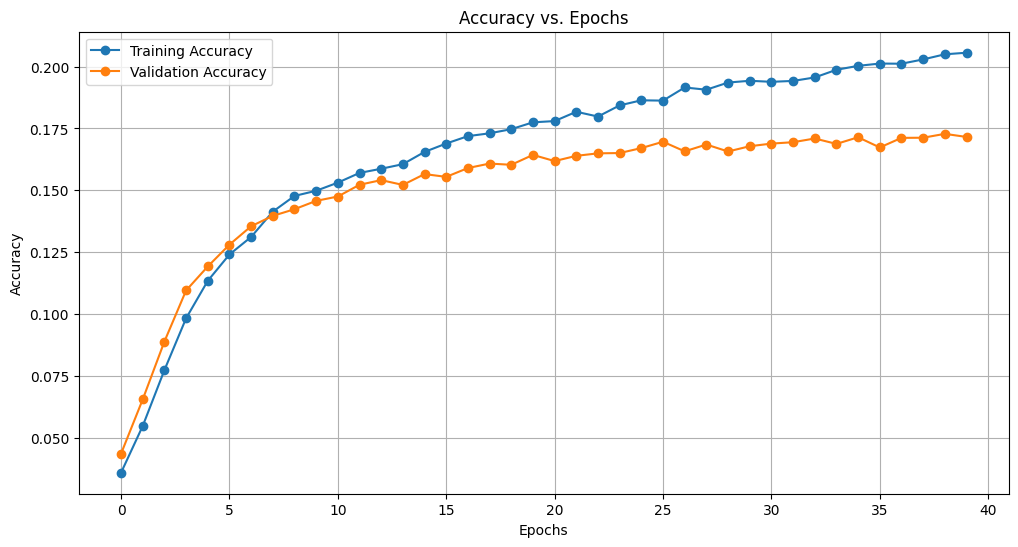

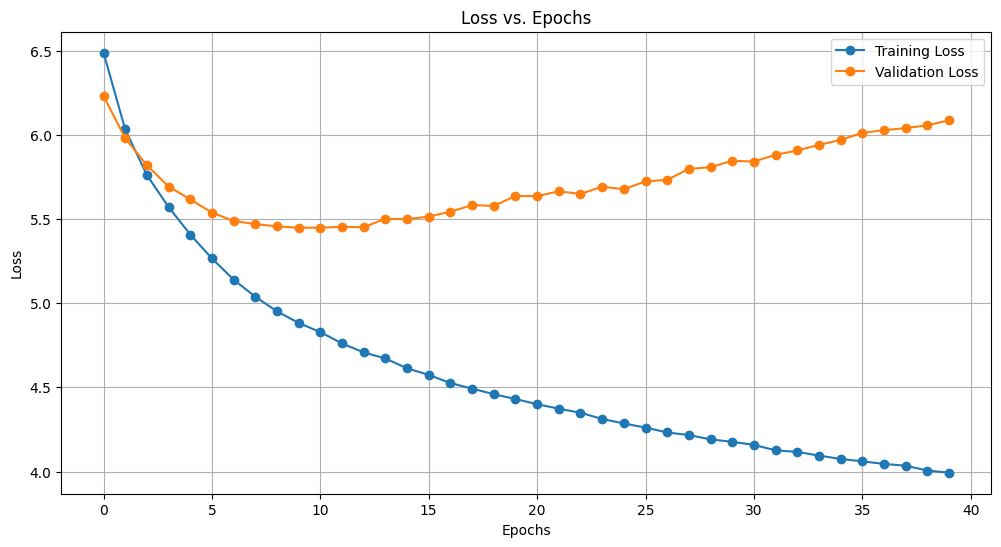

In [9]:
# 5. Plot Accuracy and Loss
import matplotlib.pyplot as plt
def plot_training_history(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title("Accuracy vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title("Loss vs. Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_training_history(history)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 71, 100)        │       874,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 71, 256)        │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 71, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8748)           │     1,128,492 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,747,478 (29.55 MB)

 Trainable params: 2,582,492 (9.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,164,986 (19.70 MB)

In [11]:
def predict_next_word(model, tokenizer, input_text, max_length):
    """
    Predict the next word given an input text.

    Args:
        model: Trained Keras model.
        tokenizer: Tokenizer used during training.
        input_text (str): Input text to predict the next word.
        max_length (int): Maximum sequence length used during training.

    Returns:
        str: Predicted next word.
    """
    try:
        # Tokenize the input text
        input_seq = tokenizer.texts_to_sequences([input_text])
        print(f"Tokenized input: {input_seq}")
        
        # Pad the sequence to the required length
        input_seq = pad_sequences(input_seq, maxlen=max_length - 1, padding='pre')
        print(f"Padded input sequence: {(input_seq)}")
        print(input_seq.shape)
        
        # Predict the next word's probabilities
        predicted_probs = model.predict(input_seq, verbose=0)
        
        # Get the index of the most probable word
        predicted_word_index = np.argmax(predicted_probs)
        
        # Map the index to the corresponding word
        predicted_word = tokenizer.index_word.get(predicted_word_index, "<OOV>")
        
        # Return the predicted word
        return predicted_word

    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Test the prediction function
input_text = "he looked at her"
predicted_word = predict_next_word(model, tokenizer, input_text, max_sequence_len)
print(f"Input: '{input_text}'")
print(f"Predicted next word: '{predicted_word}'")

Tokenized input: [[8, 254, 24, 7]]
Padded input sequence: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   8 254  24   7]]
(1, 71)
Error during prediction: Exception encountered when calling LSTM.call().

slice index -1 of dimension 0 out of bounds. for '{{node replica_1/sequential_1/lstm_1/strided_slice_3}} = StridedSlice[Index=DT_INT32, T=DT_FLOAT, begin_mask=0, ellipsis_mask=0, end_mask=0, new_axis_mask=0, shrink_axis_mask=1](replica_1/sequential_1/lstm_1/CudnnRNNV3, replica_1/sequential_1/lstm_1/strided_slice_3/stack, replica_1/sequential_1/lstm_1/strided_slice_3/stack_1, replica_1/sequential_1/lstm_1/strided_slice_3/stack_2)' with input shapes: [0,71,256], [1], [1], [1] and with computed input tensors: input[1] = <-1>, input[2] = <0>, input[3] = <1>.

Argu